# Import Modules

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from typing import Tuple, Dict
import sentencepiece as spm

# Hyperparemeters

In [2]:
# Set a random seed
torch.manual_seed(1337)
# How many independent sequences will we process in parallel?
batch_size = 64
# What is the maximum context length for prediction?
block_size = 128
# How many iterations we will be doing in our training loop
max_iters = 1
# The interval in which we want to calculate the loss. We cannot do that after each step
eval_interval = 500
# The learning rate of the model
learning_rate = 3e-4
# Use GPU to train the model. If GPU is not existed, use the CPU instead.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# The amount of iterations we use in our loss function.
eval_iters = 200
# Number of Embedding dimensions
n_embd = 384
# Number of Heads
n_head = 6
# Number of Block Layers
n_layer = 6
# Dropout
dropout = 0.2

# Tokenizer

In [3]:
with open("/kaggle/input/pretraindata/text_pretrain.txt", 'r', encoding='utf-8') as f:
  text = f.read()

In [4]:
special_tokens = ["<question>", "</question>", "<answer>", "</answer>", "<pad>"]

In [5]:
spm.SentencePieceTrainer.Train(
    input = "/kaggle/input/pretraindata/text_pretrain.txt",
    model_prefix = "model_bpe",
    vocab_size = 3000,
    user_defined_symbols = special_tokens,
    model_type = "bpe"
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /kaggle/input/pretraindata/text_pretrain.txt
  input_format: 
  model_prefix: model_bpe
  model_type: BPE
  vocab_size: 3000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <question>
  user_defined_symbols: </question>
  user_defined_symbols: <answer>
  user_defined_symbols: </answer>
  user_defined_symbols: <pad>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  u

In [6]:
sp = spm.SentencePieceProcessor()
sp.Load("/kaggle/working/model_bpe.model")

True

In [7]:
vocab_size = sp.GetPieceSize()

In [8]:
encoded_text = sp.EncodeAsIds(text)
data = torch.tensor(encoded_text, dtype=torch.long)

# Split train and test set

In [9]:
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

# Data Loader

In [10]:
class TextDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int) -> None:
        self.data = data
        self.block_size = block_size

    def __len__(self) -> int:
        return len(self.data) - self.block_size

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.data[index:index+self.block_size]
        y = self.data[index+1:index+self.block_size+1]
        return x, y

In [11]:
def get_dataloaders(
    train_data: torch.Tensor,
    val_data: torch.Tensor,
    block_size: int, 
    batch_size: int,
    device: torch.device
) -> Tuple[DataLoader, DataLoader]:
    train_dataset = TextDataset(train_data.to(device), block_size)
    val_dataset = TextDataset(val_data.to(device), block_size)
    train_loader = DataLoader(
        train_dataset, 
        batch_size = batch_size,
        shuffle = True,
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size = batch_size,
        shuffle = False,
    )
    return train_loader, val_loader

# Loss Estimater

In [12]:
@torch.no_grad()
def estimate_loss(
    model: nn.Module, 
    train_loader: DataLoader,
    val_loader: DataLoader,
    eval_iters: int
) -> Dict[str, float]:
    out = {}
    model.eval()
    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = torch.zeros(eval_iters)
        for i, (x, y) in enumerate(loader):
            if i >= eval_iters:
                break

            with torch.no_grad():
                logits, loss = model(x, y)
                losses[i] = loss.item()
        out[split] = losses.mean().item()
    model.train()
    return out

# Self Attention Head

In [13]:
class Head(nn.Module):
    '''A class that represents a single SA head'''

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v=self.value(x)
        out = wei @ v
        return out

# Multi-Head Attention

In [14]:
class MultiHeadAttention(nn.Module):
  '''multiple heads of self-attention in parallel'''

  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(head_size*num_heads, n_embd)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))
    return out

# Feed Forward

In [15]:
class FeedForward(nn.Module):
  '''a linear layer followed by a non-linearity'''
  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_embd, 4 * n_embd),
        nn.ReLU(),
        nn.Linear(4 * n_embd, n_embd),
        nn.Dropout(dropout),
    )

  def forward(self, x):
    return self.net(x)

# Layer Blocks

In [16]:
class Block(nn.Module):
  '''A Transformer block: communication followed by computation'''
  def __init__(self, n_embd, n_head):
    super().__init__()
    head_size = n_embd // n_head
    self.sa = MultiHeadAttention(n_head, head_size)
    self.ffwd = FeedForward(n_embd)
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x

# Final Model

In [17]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        print("Created the GPTLanguageModel")
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size) # Language model head
        self.apply(self.init_weights)

    def init_weights(self, module: nn.Module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    # This is not a feed forward layer, but gets us the next logits we need for the generate method
    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)

        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    # A method that will generate the next token in our timeline. So like:
    # "A ca" -> "A cat" -> "A cat " -> ...
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            # Get the current predictions. This "self" call will automatically call
            # our "forward" method above
            logits, loss = self(idx_cond)
            # focus only on the last time step (token)
            logits = logits[:, - 1, :]
            # Do a softmax to get probabilities
            probs = F.softmax(logits, dim=-1)
            # Sample from the prob distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # Append the next probable index (=token) to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [18]:
model = GPTLanguageModel()
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

Created the GPTLanguageModel
12.996792 M parameters


# Model Training

In [19]:
def save_checkpoint(
  model: GPTLanguageModel,
  optimizer: torch.optim.Optimizer,
  epoch: int,
  loss: float,
  path: str = "checkpoint.pth"
) -> None:
  checkpoint = {
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss
  }
  torch.save(checkpoint, path)

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_loader, val_loader = get_dataloaders(
    train_data=train_data,
    val_data=val_data,
    block_size=block_size,
    batch_size=batch_size,
    device=device
)

In [21]:
train_losses = []
val_losses = []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader)-1:
            losses = estimate_loss(
                model = model,
                train_loader = train_loader,
                val_loader = val_loader,
                eval_iters = min(eval_iters, len(val_loader))
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])
            print(f"iteration {iteration} / step {batch_idx}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    if iteration+1 == max_iters:
        save_checkpoint(model, optimizer, iteration+1, loss.item())

iteration 0 / step 0: train loss 8.0823, val loss 8.0864
iteration 0 / step 500: train loss 4.1991, val loss 5.1293
iteration 0 / step 1000: train loss 3.0055, val loss 5.0424
iteration 0 / step 1500: train loss 2.0916, val loss 5.2919
iteration 0 / step 2000: train loss 1.3976, val loss 5.7040
iteration 0 / step 2500: train loss 0.9190, val loss 6.1144
iteration 0 / step 3000: train loss 0.6134, val loss 6.5125
iteration 0 / step 3500: train loss 0.4445, val loss 6.8747
iteration 0 / step 4000: train loss 0.3482, val loss 7.2030
iteration 0 / step 4500: train loss 0.2922, val loss 7.4651
iteration 0 / step 5000: train loss 0.2591, val loss 7.6861
iteration 0 / step 5393: train loss 0.2414, val loss 7.8704


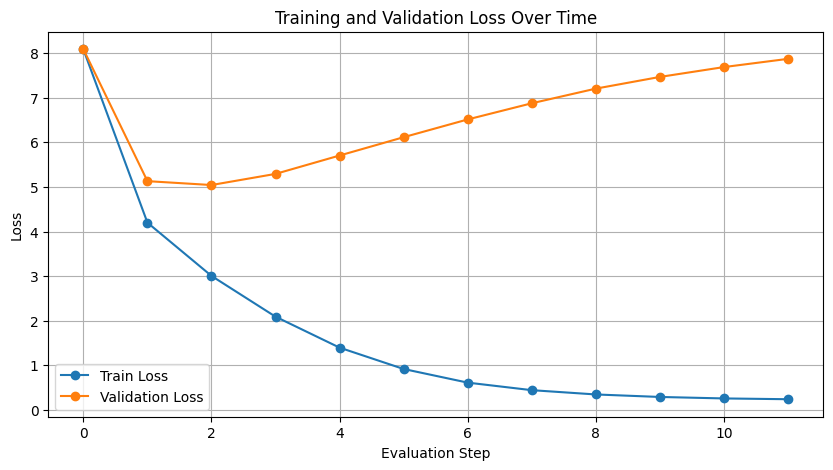

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [22]:
prompt = "She was a daughter of"
context = torch.tensor(sp.EncodeAsIds(prompt), dtype=torch.long, device=device).unsqueeze(0)
print(sp.DecodeIds(m.generate(context, max_new_tokens=100)[0].tolist()))

She was a daughter of actress. She played the mid-stley family of her long-daughter She was thought her kilck. She appeared in there and her school education. at Bachebay the Nook's school sweetia, and Beitara. She continued her career as a role in role as a supporting role as a more workingheba Norders in the mid 19696, she performed at BMTV's character


# Closure

Obviously, there is overfit. The model is trained by a small dataset. The validation dataset is small, and it may contain different topics to the train dataset. The purpose of this step is learning the language. To see the learning result, we finally generate some text. This text makes sense. So we can say that this model works.